In [149]:
#import necessary libraries
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import requests
import collections
import re
import json
from pandas.io.json import json_normalize
%matplotlib inline

In [94]:
# Read bike trip data from 2017-07 to 2019-04
tripdf=pd.DataFrame()
for filename in glob.glob("*tripdata.csv"):
    tripdf=tripdf.append(pd.read_csv(filename, parse_dates=["starttime", "stoptime"]))

In [24]:
# Inspect tripdf 
tripdf.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,463,2017-07-01 00:00:21,2017-07-01 00:08:05,22,South Station - 700 Atlantic Ave,42.352175,-71.055547,60,Charles Circle - Charles St at Cambridge St,42.360714,-71.070928,706,Subscriber,1993,1
1,689,2017-07-01 00:00:30,2017-07-01 00:12:00,22,South Station - 700 Atlantic Ave,42.352175,-71.055547,52,Newbury St at Hereford St,42.348717,-71.085954,565,Subscriber,1971,1
2,1377,2017-07-01 00:01:16,2017-07-01 00:24:14,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,567,Subscriber,1979,1
3,74,2017-07-01 00:01:28,2017-07-01 00:02:43,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,484,Subscriber,1983,1
4,480,2017-07-01 00:02:06,2017-07-01 00:10:07,120,Charles st and Beacon St,42.356052,-71.069849,52,Newbury St at Hereford St,42.348717,-71.085954,48,Subscriber,1984,1


In [25]:
# Inspect tripdf Part II
tripdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3043274 entries, 0 to 166693
Data columns (total 15 columns):
tripduration               int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 object
gender                     int64
dtypes: datetime64[ns](2), float64(4), int64(5), object(4)
memory usage: 371.5+ MB


In [95]:
# Fix the columns names in tripdf
tripdf.columns = tripdf.columns.str.replace(' ', '_')
tripdf.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender'],
      dtype='object')

In [33]:
# Inspect how many different start stations and end stations exist in tripdf
print(tripdf.start_station_name.nunique())
print(tripdf.end_station_name.nunique())

347
348


In [38]:
# Inspect any anomalies by checking tripdf.describe()
tripdf.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,gender
count,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06
mean,1.426353e+03,9.794769e+01,4.235738e+01,-7.108617e+01,9.777753e+01,4.235736e+01,-7.108581e+01,2.094717e+03,1.087222e+00
std,2.552807e+04,7.378661e+01,1.381469e-01,2.318688e-01,7.404229e+01,1.402569e-01,2.354184e-01,1.218827e+03,5.853337e-01
min,6.100000e+01,1.000000e+00,0.000000e+00,-7.116649e+01,1.000000e+00,0.000000e+00,-7.116649e+01,1.000000e+00,0.000000e+00
25%,4.020000e+02,4.500000e+01,4.234876e+01,-7.110394e+01,4.500000e+01,4.234876e+01,-7.110394e+01,1.025000e+03,1.000000e+00
50%,6.760000e+02,7.800000e+01,4.235810e+01,-7.108822e+01,7.800000e+01,4.235810e+01,-7.108809e+01,2.120000e+03,1.000000e+00
75%,1.132000e+03,1.410000e+02,4.236576e+01,-7.106629e+01,1.410000e+02,4.236567e+01,-7.106526e+01,3.089000e+03,1.000000e+00
max,9.328558e+06,3.840000e+02,4.240630e+01,0.000000e+00,3.840000e+02,4.240630e+01,0.000000e+00,4.626000e+03,2.000000e+00


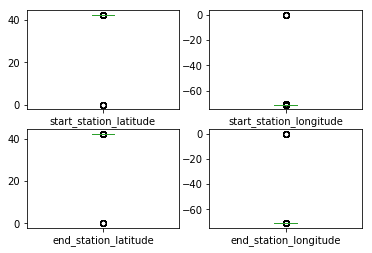

In [45]:
# Create a box plot to check outliers
fig = plt.figure()
plt.subplot(2,2,1)
tripdf.start_station_latitude.plot(kind="box")
plt.subplot(2,2,2)
tripdf.start_station_longitude.plot(kind="box")
plt.subplot(2,2,3)
tripdf.end_station_latitude.plot(kind="box")
plt.subplot(2,2,4)
tripdf.end_station_longitude.plot(kind="box")
# Conclusion: it seems like there are (lat, long)=(0,0) outliers

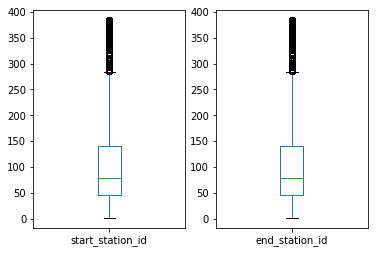

In [50]:
# Checking start and end station id's
fig = plt.figure()
plt.subplot(1,2,1)
tripdf.start_station_id.plot(kind="box")
plt.subplot(1,2,2)
tripdf.end_station_id.plot(kind="box")

# Conclusison: it is not clear if 270~400 are newer stations and show less often in trip histories or not. 

In [59]:
tripdf.start_station_id.max()

384

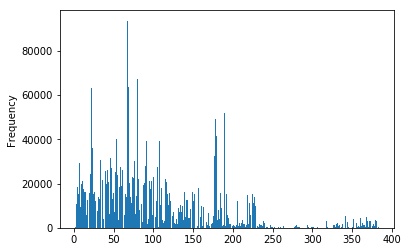

In [60]:
tripdf.start_station_id.plot(kind="hist", bins=384)

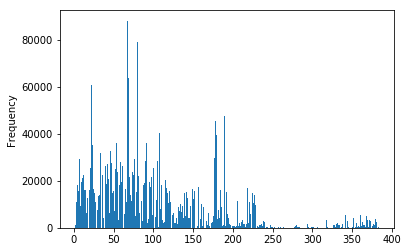

In [61]:
tripdf.end_station_id.plot(kind="hist", bins=384)

In [147]:
# They all seem like valid stations 
print(tripdf.groupby("start_station_id").first()[0:10])
print(tripdf.groupby("start_station_id").first()[220:250])

                                                   end_station_name  \
start_station_id                                                      
1                                             18 Dorrance Warehouse   
3                                         Longwood Ave at Binney St   
4                                  South Station - 700 Atlantic Ave   
5                                      MIT at Mass Ave / Amherst St   
6                                                Ames St at Main St   
7                                                W Broadway at D St   
8                     One Broadway / Kendall Sq at Main St / 3rd St   
9                       Northeastern University - North Parking Lot   
10                Packard's Corner - Commonwealth Ave at Brighto...   
11                                     Commonwealth Ave at Buick St   

                                                 start_station_name  \
start_station_id                                                      
1    

In [76]:
tripdf.groupby("start_station_name").first().sort_values(["start_station_latitude", "start_station_longitude"])

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
start_station_name,,,,,,,,,,,,,,
8D OPS 01,231,2018-07-18 15:07:22.585,2018-07-18 15:11:13.793,158,0.000000,0.000000,158,8D OPS 01,0.000000,0.000000,1583,Customer,1969,0
8D QC Station 01,881,2017-09-08 13:00:13.000,2017-09-08 13:14:55.000,229,0.000000,0.000000,229,8D QC Station 01,0.000000,0.000000,1583,Customer,\N,0
8D QC Station 02,219,2017-09-12 15:29:49.000,2017-09-12 15:33:29.000,230,0.000000,0.000000,230,8D QC Station 02,0.000000,0.000000,1583,Customer,\N,0
Test 000e3,1457,2017-10-18 16:27:03.000,2017-10-18 16:51:21.000,164,0.000000,0.000000,22,South Station - 700 Atlantic Ave,42.352175,-71.055547,1132,Subscriber,1957,1
BCBS Hingham,824,2018-10-29 16:23:44.975,2018-10-29 16:37:29.488,308,42.167226,-70.905558,308,BCBS Hingham,42.167226,-70.905558,4253,Subscriber,1965,2
Mattapan T Stop,4337,2018-08-30 15:36:06.307,2018-08-30 16:48:23.509,241,42.267902,-71.093641,241,Mattapan T Stop,42.267902,-71.093641,2349,Customer,1969,0
Mattapan T Stop (former),78,2018-10-04 17:54:39.345,2018-10-04 17:55:57.656,241,42.267902,-71.093641,241,Mattapan T Stop (former),42.267902,-71.093641,4210,Customer,1996,2
Blue Hill Ave at Almont St,3752,2018-08-26 20:39:43.242,2018-08-26 21:42:15.569,245,42.274545,-71.093720,245,Blue Hill Ave at Almont St,42.274545,-71.093720,4161,Customer,1969,0
Blue Hill Ave at Almont St (former),1779,2018-10-02 08:10:15.093,2018-10-02 08:39:55.060,245,42.274545,-71.093720,253,Thetford Ave at Norfolk St (former),42.286251,-71.079463,3549,Subscriber,1987,2


In [77]:
tripdf.groupby("end_station_name").first().sort_values("end_station_latitude")

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
end_station_name,,,,,,,,,,,,,,
8D QC Station 02,219,2017-09-12 15:29:49.000,2017-09-12 15:33:29.000,230,8D QC Station 02,0.000000,0.000000,230,0.000000,0.000000,1583,Customer,\N,0
Lab PBSC,184,2018-02-15 14:06:12.000,2018-02-15 14:09:16.000,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,164,0.000000,0.000000,1743,Subscriber,1992,1
8D QC Station 01,881,2017-09-08 13:00:13.000,2017-09-08 13:14:55.000,229,8D QC Station 01,0.000000,0.000000,229,0.000000,0.000000,1583,Customer,\N,0
8D OPS 01,231,2018-07-18 15:07:22.585,2018-07-18 15:11:13.793,158,8D OPS 01,0.000000,0.000000,158,0.000000,0.000000,1583,Customer,1969,0
Test 000e3,337,2017-10-18 15:43:25.000,2017-10-18 15:49:03.000,33,Kenmore Square,42.348706,-71.097009,164,0.000000,0.000000,1809,Subscriber,1990,1
BCBS Hingham,824,2018-10-29 16:23:44.975,2018-10-29 16:37:29.488,308,BCBS Hingham,42.167226,-70.905558,308,42.167226,-70.905558,4253,Subscriber,1965,2
Mattapan T Stop,2845773,2018-08-24 11:02:44.435,2018-09-26 09:32:18.347,162,Franklin Park - Seaver St at Humbolt Ave,42.309796,-71.092225,241,42.267902,-71.093641,3535,Customer,1988,2
Mattapan T Stop (former),293,2018-10-03 07:46:08.218,2018-10-03 07:51:02.173,263,Mattapan Library (former),42.277389,-71.093250,241,42.267902,-71.093641,3904,Subscriber,1987,2
Blue Hill Ave at Almont St (former),1705,2018-10-06 13:10:31.659,2018-10-06 13:38:57.611,263,Mattapan Library (former),42.277389,-71.093250,245,42.274545,-71.093720,3690,Subscriber,1987,2


8D OPS 01, Test 000e3, 8D QC Station 01, 8D QC Station 02, Lab PBSC are invalid stations. Remove any trip history that starts with or ends at these stations. 

In [96]:
# 8D OPS 01, Test 000e3, 8D QC Station 01, 8D QC Station 02, Lab PBSC are invalid stations. 
# Remove any trip history that starts with or ends at these stations. 
tripdf=tripdf.set_index("start_station_name").drop(["8D OPS 01", "Test 000e3", "8D QC Station 01", "8D QC Station 02"])


In [99]:
tripdf=tripdf.reset_index()
tripdf.head()

,start_station_name,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,South Station - 700 Atlantic Ave,463,2017-07-01 00:00:21,2017-07-01 00:08:05,22,42.352175,-71.055547,60,Charles Circle - Charles St at Cambridge St,42.360714,-71.070928,706,Subscriber,1993,1
1,South Station - 700 Atlantic Ave,689,2017-07-01 00:00:30,2017-07-01 00:12:00,22,42.352175,-71.055547,52,Newbury St at Hereford St,42.348717,-71.085954,565,Subscriber,1971,1
2,Packard's Corner - Commonwealth Ave at Brighto...,1377,2017-07-01 00:01:16,2017-07-01 00:24:14,41,42.352261,-71.123831,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,567,Subscriber,1979,1
3,359 Broadway - Broadway at Fayette Street,74,2017-07-01 00:01:28,2017-07-01 00:02:43,116,42.370803,-71.104412,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,484,Subscriber,1983,1
4,Charles st and Beacon St,480,2017-07-01 00:02:06,2017-07-01 00:10:07,120,42.356052,-71.069849,52,Newbury St at Hereford St,42.348717,-71.085954,48,Subscriber,1984,1


In [100]:
tripdf.groupby("end_station_name").first().sort_values("end_station_latitude")

,start_station_name,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
end_station_name,,,,,,,,,,,,,,
Lab PBSC,One Kendall Square at Hampshire St / Portland St,184,2018-02-15 14:06:12.000,2018-02-15 14:09:16.000,91,42.366277,-71.091690,164,0.000000,0.000000,1743,Subscriber,1992,1
Test 000e3,Kenmore Square,337,2017-10-18 15:43:25.000,2017-10-18 15:49:03.000,33,42.348706,-71.097009,164,0.000000,0.000000,1809,Subscriber,1990,1
BCBS Hingham,BCBS Hingham,824,2018-10-29 16:23:44.975,2018-10-29 16:37:29.488,308,42.167226,-70.905558,308,42.167226,-70.905558,4253,Subscriber,1965,2
Mattapan T Stop (former),Mattapan Library (former),293,2018-10-03 07:46:08.218,2018-10-03 07:51:02.173,263,42.277389,-71.093250,241,42.267902,-71.093641,3904,Subscriber,1987,2
Mattapan T Stop,Franklin Park - Seaver St at Humbolt Ave,2845773,2018-08-24 11:02:44.435,2018-09-26 09:32:18.347,162,42.309796,-71.092225,241,42.267902,-71.093641,3535,Customer,1988,2
Blue Hill Ave at Almont St (former),Mattapan Library (former),1705,2018-10-06 13:10:31.659,2018-10-06 13:38:57.611,263,42.277389,-71.093250,245,42.274545,-71.093720,3690,Subscriber,1987,2
Blue Hill Ave at Almont St,Blue Hill Ave at Almont St,3752,2018-08-26 20:39:43.242,2018-08-26 21:42:15.569,245,42.274545,-71.093720,245,42.274545,-71.093720,4161,Customer,1969,0
BCBS Quincy,BCBS Quincy,673,2018-10-29 13:55:00.396,2018-10-29 14:06:13.998,317,42.276005,-71.039250,317,42.276005,-71.039250,4273,Subscriber,1979,2
Mattapan Library (former),Mattapan Library (former),628,2018-10-01 15:58:38.604,2018-10-01 16:09:06.776,263,42.277389,-71.093250,263,42.277389,-71.093250,3327,Subscriber,1987,2


In [101]:
tripdf=tripdf.set_index("end_station_name").drop(["Test 000e3", "Lab PBSC"])
tripdf=tripdf.reset_index()

In [102]:
# Hopefully all cleaned
tripdf.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,gender
count,3.043218e+06,3.043218e+06,3.043218e+06,3.043218e+06,3.043218e+06,3.043218e+06,3.043218e+06,3.043218e+06,3.043218e+06
mean,1.425252e+03,9.794676e+01,4.235782e+01,-7.108692e+01,9.777678e+01,4.235782e+01,-7.108658e+01,2.094736e+03,1.087224e+00
std,2.545445e+04,7.378644e+01,1.479581e-02,2.505500e-02,7.404215e+01,1.472470e-02,2.503004e-02,1.218828e+03,5.853306e-01
min,6.100000e+01,1.000000e+00,4.216723e+01,-7.116649e+01,1.000000e+00,4.216723e+01,-7.116649e+01,1.000000e+00,0.000000e+00
25%,4.020000e+02,4.500000e+01,4.234876e+01,-7.110394e+01,4.500000e+01,4.234876e+01,-7.110394e+01,1.025000e+03,1.000000e+00
50%,6.760000e+02,7.800000e+01,4.235810e+01,-7.108822e+01,7.800000e+01,4.235810e+01,-7.108809e+01,2.120000e+03,1.000000e+00
75%,1.132000e+03,1.410000e+02,4.236576e+01,-7.106629e+01,1.410000e+02,4.236567e+01,-7.106526e+01,3.089000e+03,1.000000e+00
max,9.328558e+06,3.840000e+02,4.240630e+01,-7.090556e+01,3.840000e+02,4.240630e+01,-7.090556e+01,4.626000e+03,2.000000e+00


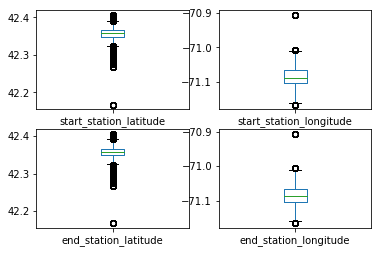

In [103]:
fig = plt.figure()
plt.subplot(2,2,1)
tripdf.start_station_latitude.plot(kind="box")
plt.subplot(2,2,2)
tripdf.start_station_longitude.plot(kind="box")
plt.subplot(2,2,3)
tripdf.end_station_latitude.plot(kind="box")
plt.subplot(2,2,4)
tripdf.end_station_longitude.plot(kind="box")

In [271]:
endgeo=tripdf.groupby(["end_station_latitude", "end_station_longitude"]).agg({'end_station_name':"first"})
endgeo=endgeo.reset_index()
endgeo.head(10)

,end_station_latitude,end_station_longitude,end_station_name
0,42.167226,-70.905558,BCBS Hingham
1,42.267902,-71.093641,Mattapan T Stop
2,42.274545,-71.093720,Blue Hill Ave at Almont St
3,42.274621,-71.093726,Blue Hill Ave at Almont St
4,42.276005,-71.039250,BCBS Quincy
5,42.277389,-71.093250,Mattapan Library
6,42.280725,-71.086172,Morton St T
7,42.280754,-71.086218,Morton St T
8,42.282976,-71.054667,Gallivan Blvd at Adams St
9,42.286153,-71.128374,Roslindale Village - Washington St


In [270]:
# Include id as well as name
endgeo2=tripdf.groupby(["end_station_latitude", "end_station_longitude"]).agg({'end_station_name':"first", "end_station_id":"first"})
endgeo2=endgeo2.reset_index()
endgeo2.head(10)

,end_station_latitude,end_station_longitude,end_station_name,end_station_id
0,42.167226,-70.905558,BCBS Hingham,308
1,42.267902,-71.093641,Mattapan T Stop,241
2,42.274545,-71.093720,Blue Hill Ave at Almont St,245
3,42.274621,-71.093726,Blue Hill Ave at Almont St,340
4,42.276005,-71.039250,BCBS Quincy,317
5,42.277389,-71.093250,Mattapan Library,263
6,42.280725,-71.086172,Morton St T,343
7,42.280754,-71.086218,Morton St T,248
8,42.282976,-71.054667,Gallivan Blvd at Adams St,258
9,42.286153,-71.128374,Roslindale Village - Washington St,246


In [182]:
#Include id as well as name
startgeo2=tripdf.groupby(["start_station_latitude", "start_station_longitude"]).agg({'start_station_name':"first", "start_station_id":"first"})
startgeo2=startgeo2.reset_index()
startgeo2.head(20)

,start_station_latitude,start_station_longitude,start_station_name,start_station_id
0,42.167226,-70.905558,BCBS Hingham,308
1,42.267902,-71.093641,Mattapan T Stop,241
2,42.274545,-71.093720,Blue Hill Ave at Almont St,245
3,42.274621,-71.093726,Blue Hill Ave at Almont St,340
4,42.276005,-71.039250,BCBS Quincy,317
5,42.277389,-71.093250,Mattapan Library,263
6,42.280725,-71.086172,Morton St T,343
7,42.280754,-71.086218,Morton St T,248
8,42.282976,-71.054667,Gallivan Blvd at Adams St,258
9,42.286153,-71.128374,Roslindale Village - Washington St,246


In [122]:
startgeo=tripdf.groupby(["start_station_latitude", "start_station_longitude"]).agg({'start_station_name':"first"})
startgeo=startgeo.reset_index()
startgeo.head(20)

,start_station_latitude,start_station_longitude,start_station_name
0,42.167226,-70.905558,BCBS Hingham
1,42.267902,-71.093641,Mattapan T Stop
2,42.274545,-71.093720,Blue Hill Ave at Almont St
3,42.274621,-71.093726,Blue Hill Ave at Almont St
4,42.276005,-71.039250,BCBS Quincy
5,42.277389,-71.093250,Mattapan Library
6,42.280725,-71.086172,Morton St T
7,42.280754,-71.086218,Morton St T
8,42.282976,-71.054667,Gallivan Blvd at Adams St
9,42.286153,-71.128374,Roslindale Village - Washington St


Investigate BCBS Hingham. It is not on the system map. Lots of duplicates or missing data

Merge with station

In [114]:
# Read in station information 
station = pd.read_csv("Hubway_Stations_as_of_July_2017.csv")

In [115]:
# Inspect station 
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 7 columns):
Station ID         281 non-null object
Station            281 non-null object
Latitude           281 non-null float64
Longitude          281 non-null float64
Municipality       281 non-null object
publiclyExposed    281 non-null int64
# of Docks         281 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 15.4+ KB


In [116]:
# Inspect station Part II
station.head()

,Station ID,Station,Latitude,Longitude,Municipality,publiclyExposed,# of Docks
0,A32019,175 N Harvard St,42.363796,-71.129164,Boston,1,18
1,S32035,191 Beacon St,42.380323,-71.108786,Somerville,1,15
2,S32023,30 Dane St.,42.381001,-71.104025,Somerville,1,15
3,M32026,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,Cambridge,1,23
4,M32054,699 Mt Auburn St,42.375002,-71.148716,Cambridge,1,25


In [124]:
# Merge startgeo (one station name is associated with multiple lat/long entries) and station information 
# to find out the correct geographic information

startmerge=pd.merge(startgeo, station, left_on="start_station_name", right_on="Station", how="left")


In [131]:
startmerge.head(20)

,start_station_latitude,start_station_longitude,start_station_name,Station ID,Station,Latitude,Longitude,Municipality,publiclyExposed,# of Docks
0,42.167226,-70.905558,BCBS Hingham,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42.267902,-71.093641,Mattapan T Stop,C32045,Mattapan T Stop,42.267902,-71.093641,Boston,1.0,15.0
2,42.274545,-71.093720,Blue Hill Ave at Almont St,C32044,Blue Hill Ave at Almont St,42.274621,-71.093726,Boston,1.0,19.0
3,42.274621,-71.093726,Blue Hill Ave at Almont St,C32044,Blue Hill Ave at Almont St,42.274621,-71.093726,Boston,1.0,19.0
4,42.276005,-71.039250,BCBS Quincy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,42.277389,-71.093250,Mattapan Library,C32050,Mattapan Library,42.277389,-71.093250,Boston,1.0,15.0
6,42.280725,-71.086172,Morton St T,C23045,Morton St T,42.280725,-71.086172,Boston,1.0,15.0
7,42.280754,-71.086218,Morton St T,C23045,Morton St T,42.280725,-71.086172,Boston,1.0,15.0
8,42.282976,-71.054667,Gallivan Blvd at Adams St,C32040,Gallivan Blvd at Adams St,42.282976,-71.054667,Boston,1.0,15.0
9,42.286153,-71.128374,Roslindale Village - Washington St,C32046,Roslindale Village - Washington St,42.286307,-71.128205,Boston,1.0,15.0


In [272]:
# List of stations appeared in tripdf but not in Station info. 
startmerge[startmerge["Station ID"].isnull()].head(10)

,start_station_latitude,start_station_longitude,start_station_name,Station ID,Station,Latitude,Longitude,Municipality,publiclyExposed,# of Docks
0,42.167226,-70.905558,BCBS Hingham,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42.276005,-71.039250,BCBS Quincy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,42.317840,-71.077960,Blue Hill Ave at Southwood St (former),NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,42.332891,-71.116583,Brookline Village - Station Street @ MBTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,42.333765,-71.120464,Brookline Village - Station Street @ MBTA TEMP...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,42.338254,-71.139055,Washington Square at Washington St. / Beacon S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,42.338267,-71.138947,Washington Square at Washington St. / Beacon St.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,42.338850,-71.081406,Tremont St at Northampton St (former),NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,42.339335,-71.134930,Washington Square at Washington St. / Beacon St.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,42.341598,-71.123338,Coolidge Corner - Beacon St @ Centre St,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [264]:
# Check BSBS Quincy and BCBS Hingham
tripdf[(tripdf.start_station_name=="BCBS Quincy") | (tripdf.start_station_name=="BCBS Hingham")].head(10)

# According to the current system map they do not exist

,end_station_name,start_station_name,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
2402826,BCBS Quincy,BCBS Quincy,673,2018-10-29 13:55:00.396,2018-10-29 14:06:13.998,317,42.276005,-71.039250,317,42.276005,-71.039250,4273,Subscriber,1979,2
2403483,BCBS Hingham,BCBS Hingham,824,2018-10-29 16:23:44.975,2018-10-29 16:37:29.488,308,42.167226,-70.905558,308,42.167226,-70.905558,4253,Subscriber,1965,2
2403837,BCBS Quincy,BCBS Quincy,1162,2018-10-29 17:01:09.006,2018-10-29 17:20:31.151,317,42.276005,-71.039250,317,42.276005,-71.039250,4260,Subscriber,1960,2
2408844,BCBS Hingham,BCBS Hingham,1381,2018-10-30 12:36:53.158,2018-10-30 12:59:54.738,308,42.167226,-70.905558,308,42.167226,-70.905558,4249,Subscriber,1971,2
2408845,BCBS Hingham,BCBS Hingham,1419,2018-10-30 12:36:53.651,2018-10-30 13:00:33.512,308,42.167226,-70.905558,308,42.167226,-70.905558,4250,Subscriber,1966,2
2409303,BCBS Quincy,BCBS Quincy,975,2018-10-30 14:22:31.271,2018-10-30 14:38:46.525,317,42.276005,-71.039250,317,42.276005,-71.039250,4273,Subscriber,1990,2
2410818,BCBS Hingham,BCBS Hingham,699,2018-10-30 17:23:27.465,2018-10-30 17:35:07.220,308,42.167226,-70.905558,308,42.167226,-70.905558,4253,Subscriber,1965,2
2415444,BCBS Hingham,BCBS Hingham,854,2018-10-31 11:30:56.761,2018-10-31 11:45:10.928,308,42.167226,-70.905558,308,42.167226,-70.905558,4247,Subscriber,1964,2
2415734,BCBS Quincy,BCBS Quincy,1236,2018-10-31 12:09:16.279,2018-10-31 12:29:52.680,317,42.276005,-71.039250,317,42.276005,-71.039250,4268,Subscriber,1985,1
2415919,BCBS Hingham,BCBS Hingham,1736,2018-10-31 12:35:55.758,2018-10-31 13:04:52.084,308,42.167226,-70.905558,308,42.167226,-70.905558,4251,Subscriber,1971,2


In [ ]:
# Blue Hill Ave at Southwood St Bike station: B32057, 14 docks
# Blue Hill Ave at Southwood St (former) exists 

Manually check if these stations are in system the map

In [265]:
startmerge [ startmerge.start_station_latitude != startmerge.Latitude].head()

,start_station_latitude,start_station_longitude,start_station_name,Station ID,Station,Latitude,Longitude,Municipality,publiclyExposed,# of Docks
0,42.167226,-70.905558,BCBS Hingham,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42.274545,-71.093720,Blue Hill Ave at Almont St,C32044,Blue Hill Ave at Almont St,42.274621,-71.093726,Boston,1.0,19.0
3,42.274621,-71.093726,Blue Hill Ave at Almont St,C32044,Blue Hill Ave at Almont St,42.274621,-71.093726,Boston,1.0,19.0
4,42.276005,-71.039250,BCBS Quincy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,42.280725,-71.086172,Morton St T,C23045,Morton St T,42.280725,-71.086172,Boston,1.0,15.0


In [266]:
# Round the numbers to match 
startmerge [ startmerge.start_station_latitude.round(6) != startmerge.Latitude.round(6)].head()

,start_station_latitude,start_station_longitude,start_station_name,Station ID,Station,Latitude,Longitude,Municipality,publiclyExposed,# of Docks
0,42.167226,-70.905558,BCBS Hingham,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42.274545,-71.093720,Blue Hill Ave at Almont St,C32044,Blue Hill Ave at Almont St,42.274621,-71.093726,Boston,1.0,19.0
4,42.276005,-71.039250,BCBS Quincy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,42.280754,-71.086218,Morton St T,C23045,Morton St T,42.280725,-71.086172,Boston,1.0,15.0
9,42.286153,-71.128374,Roslindale Village - Washington St,C32046,Roslindale Village - Washington St,42.286307,-71.128205,Boston,1.0,15.0


Seems like two many unmatched stations. Use the current system info to build a better station dataset

In [269]:
# Call the API and pull out data
# into the JSON structure that will be returned
r = requests.get("https://member.bluebikes.com/data/stations.json")
bike_data = r.json()
print(bike_data)

{'stations': [{'id': 3, 's': 'Colleges of the Fenway - Fenway at Avenue Louis Pasteur', 'n': 'B32006', 'st': 1, 'b': False, 'su': False, 'm': False, 'lu': 1558901153999, 'lc': 1558902341148, 'bk': True, 'bl': True, 'la': 42.34011512249236, 'lo': -71.10061883926392, 'da': 12, 'dx': 0, 'ba': 3, 'bx': 0, 'd': 'Boston'}, {'id': 4, 's': 'Tremont St at E Berkeley St', 'n': 'C32000', 'st': 1, 'b': False, 'su': False, 'm': False, 'lu': 1558901831657, 'lc': 1558902311494, 'bk': False, 'bl': False, 'la': 42.345392, 'lo': -71.069616, 'da': 7, 'dx': 0, 'ba': 11, 'bx': 1, 'd': 'Boston'}, {'id': 5, 's': 'Northeastern University - North Parking Lot', 'n': 'B32012', 'st': 1, 'b': False, 'su': False, 'm': False, 'lu': 1558902063958, 'lc': 1558902302394, 'bk': False, 'bl': False, 'la': 42.341814, 'lo': -71.090179, 'da': 12, 'dx': 0, 'ba': 1, 'bx': 2, 'd': 'Boston'}, {'id': 6, 's': 'Cambridge St at Joy St', 'n': 'D32000', 'st': 1, 'b': False, 'su': False, 'm': False, 'lu': 1558902277060, 'lc': 1558902399

In [151]:
bike_data.keys()

dict_keys(['stations', 'schemeSuspended', 'timestamp'])

In [178]:
station_uptodate=json_normalize(bike_data["stations"])

In [180]:
station_uptodate.head(10)

,b,ba,bk,bl,bx,d,da,dx,id,la,lc,lo,lu,m,n,s,st,su
0,False,2,True,True,0,Boston,13,0,3,42.340115,1.558899e+12,-71.100619,1558898420923,False,B32006,Colleges of the Fenway - Fenway at Avenue Loui...,1,False
1,False,15,False,False,1,Boston,3,0,4,42.345392,1.558899e+12,-71.069616,1558897750917,False,C32000,Tremont St at E Berkeley St,1,False
2,False,2,False,False,2,Boston,11,0,5,42.341814,1.558899e+12,-71.090179,1558897787162,False,B32012,Northeastern University - North Parking Lot,1,False
3,False,12,False,False,1,Boston,2,0,6,42.361212,1.558899e+12,-71.065306,1558898308637,False,D32000,Cambridge St at Joy St,1,False
4,False,5,False,False,2,Boston,8,0,7,42.353391,1.558899e+12,-71.044571,1558897905241,False,A32000,Fan Pier,1,False
5,False,12,False,False,2,Boston,5,0,8,42.353334,1.558899e+12,-71.137313,1558898316805,False,A32001,Union Square - Brighton Ave at Cambridge St,1,False
6,False,6,False,False,2,Boston,6,0,9,42.351692,1.558899e+12,-71.119035,1558898220330,False,A32002,Commonwealth Ave at Agganis Way,1,False
7,False,5,False,False,1,Boston,5,0,10,42.350406,1.558899e+12,-71.108279,1558898288625,False,A32003,B.U. Central - 725 Comm. Ave.,1,False
8,False,13,False,False,0,Boston,2,0,11,42.338629,1.558899e+12,-71.106500,1558898593149,False,A32004,Longwood Ave at Binney St,1,False
9,False,2,True,True,1,Boston,15,0,12,42.336244,1.558899e+12,-71.087986,1558898433278,False,B32002,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,1,False


In [183]:
station_uptodate=station_uptodate[["id", "n", "s", "la", "lo", "d", "da"]]

In [184]:
station_uptodate.columns=["simple_ID", "Station_ID", "Station", "Latitude", "Longtitude", "Municipality", "#_of_Docks"]

In [185]:
station_uptodate.head(10)

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
0,3,B32006,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,13
1,4,C32000,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,3
2,5,B32012,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,11
3,6,D32000,Cambridge St at Joy St,42.361212,-71.065306,Boston,2
4,7,A32000,Fan Pier,42.353391,-71.044571,Boston,8
5,8,A32001,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,Boston,5
6,9,A32002,Commonwealth Ave at Agganis Way,42.351692,-71.119035,Boston,6
7,10,A32003,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,Boston,5
8,11,A32004,Longwood Ave at Binney St,42.338629,-71.106500,Boston,2
9,12,B32002,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,Boston,15


In [177]:
station_uptodate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 6 columns):
Station ID      277 non-null object
Station         277 non-null object
Latitude        277 non-null float64
Longtitude      277 non-null float64
Municipality    277 non-null object
# of Docks      277 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 13.1+ KB


In [247]:
tripsimple=tripdf[["start_station_id", "start_station_name","end_station_id", "end_station_name","starttime", "stoptime", "tripduration", "bikeid", "usertype", "birth_year"]]

In [248]:
tripsimple.head(20)

,start_station_id,start_station_name,end_station_id,end_station_name,starttime,stoptime,tripduration,bikeid,usertype,birth_year
0,22,South Station - 700 Atlantic Ave,60,Charles Circle - Charles St at Cambridge St,2017-07-01 00:00:21,2017-07-01 00:08:05,463,706,Subscriber,1993
1,22,South Station - 700 Atlantic Ave,52,Newbury St at Hereford St,2017-07-01 00:00:30,2017-07-01 00:12:00,689,565,Subscriber,1971
2,41,Packard's Corner - Commonwealth Ave at Brighto...,88,Inman Square at Vellucci Plaza / Hampshire St,2017-07-01 00:01:16,2017-07-01 00:24:14,1377,567,Subscriber,1979
3,116,359 Broadway - Broadway at Fayette Street,116,359 Broadway - Broadway at Fayette Street,2017-07-01 00:01:28,2017-07-01 00:02:43,74,484,Subscriber,1983
4,120,Charles st and Beacon St,52,Newbury St at Hereford St,2017-07-01 00:02:06,2017-07-01 00:10:07,480,48,Subscriber,1984
5,116,359 Broadway - Broadway at Fayette Street,73,Harvard Square at Brattle St / Eliot St,2017-07-01 00:02:53,2017-07-01 00:09:27,393,11,Subscriber,1983
6,76,Central Sq Post Office / Cambridge City Hall a...,87,Harvard University Housing - 115 Putnam Ave at...,2017-07-01 00:03:53,2017-07-01 00:08:23,269,364,Subscriber,1993
7,43,Rowes Wharf at Atlantic Ave,23,Boston City Hall - 28 State St,2017-07-01 00:04:34,2017-07-01 00:25:01,1227,1163,Customer,\N
8,43,Rowes Wharf at Atlantic Ave,23,Boston City Hall - 28 State St,2017-07-01 00:05:07,2017-07-01 00:25:17,1210,767,Customer,\N
9,51,Washington St at Lenox St,26,Washington St at Waltham St,2017-07-01 00:07:34,2017-07-01 00:12:58,323,1062,Subscriber,1979


In [232]:
tripsimple.start_station_id.nunique()

317

In [206]:
startmerge3=pd.merge(tripsimple, station_uptodate, left_on="start_station_id", right_on="simple_ID", how="left")

In [273]:
startmerge3[startmerge3.simple_ID.isnull()]

,start_station_id,start_station_name,end_station_id,end_station_name,starttime,stoptime,tripduration,bikeid,usertype,birth_year,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
47,88,Inman Square at Vellucci Plaza / Hampshire St,71,Conway Park - Somerville Avenue,2017-07-01 00:47:41.000,2017-07-01 00:58:26.000,644,382,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,88,Inman Square at Vellucci Plaza / Hampshire St,67,MIT at Mass Ave / Amherst St,2017-07-01 00:59:22.000,2017-07-01 02:00:04.000,3642,437,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,88,Inman Square at Vellucci Plaza / Hampshire St,67,MIT at Mass Ave / Amherst St,2017-07-01 01:01:23.000,2017-07-01 02:00:11.000,3527,1912,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,88,Inman Square at Vellucci Plaza / Hampshire St,67,MIT at Mass Ave / Amherst St,2017-07-01 01:03:47.000,2017-07-01 02:00:19.000,3391,756,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,88,Inman Square at Vellucci Plaza / Hampshire St,110,Harvard University Gund Hall at Quincy St / Ki...,2017-07-01 01:25:38.000,2017-07-01 01:33:37.000,478,1938,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,88,Inman Square at Vellucci Plaza / Hampshire St,110,Harvard University Gund Hall at Quincy St / Ki...,2017-07-01 01:25:44.000,2017-07-01 01:33:41.000,476,1439,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,88,Inman Square at Vellucci Plaza / Hampshire St,110,Harvard University Gund Hall at Quincy St / Ki...,2017-07-01 01:26:13.000,2017-07-01 01:33:27.000,434,699,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,88,Inman Square at Vellucci Plaza / Hampshire St,110,Harvard University Gund Hall at Quincy St / Ki...,2017-07-01 01:26:26.000,2017-07-01 01:33:33.000,427,888,Subscriber,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,88,Inman Square at Vellucci Plaza / Hampshire St,139,Dana Park,2017-07-01 02:36:44.000,2017-07-01 02:45:30.000,526,999,Subscriber,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,88,Inman Square at Vellucci Plaza / Hampshire St,115,Porter Square Station,2017-07-01 03:30:05.000,2017-07-01 03:39:14.000,549,454,Subscriber,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
startmerge3[startmerge3.simple_ID.isnull()].groupby("start_station_id").count().index

Int64Index([  1,  13,  88, 155, 168, 220, 231, 237, 238, 240, 241, 242, 243,
            244, 245, 246, 247, 248, 249, 250, 252, 253, 254, 256, 257, 262,
            263, 264, 274, 277, 278, 281, 283, 284, 286, 293, 294, 295, 299,
            300, 302, 306, 307, 308, 311, 317],
           dtype='int64', name='start_station_id')

In [243]:
tripsimple.head()

,start_station_name,end_station_id,end_station_name,starttime,stoptime,tripduration,bikeid,usertype,birth_year
start_station_id,,,,,,,,,
22,South Station - 700 Atlantic Ave,60,Charles Circle - Charles St at Cambridge St,2017-07-01 00:00:21,2017-07-01 00:08:05,463,706,Subscriber,1993
22,South Station - 700 Atlantic Ave,52,Newbury St at Hereford St,2017-07-01 00:00:30,2017-07-01 00:12:00,689,565,Subscriber,1971
41,Packard's Corner - Commonwealth Ave at Brighto...,88,Inman Square at Vellucci Plaza / Hampshire St,2017-07-01 00:01:16,2017-07-01 00:24:14,1377,567,Subscriber,1979
116,359 Broadway - Broadway at Fayette Street,116,359 Broadway - Broadway at Fayette Street,2017-07-01 00:01:28,2017-07-01 00:02:43,74,484,Subscriber,1983
120,Charles st and Beacon St,52,Newbury St at Hereford St,2017-07-01 00:02:06,2017-07-01 00:10:07,480,48,Subscriber,1984


In [306]:
# station id [1,  13,  88, 155, 168, 220, 231, 237, 238, 240, 241, 242, 243, 
# 244, 245, 246, 247, 248, 249, 250, 252, 253, 254, 256, 257, 262,
# 263, 264, 274, 277, 278, 281, 283, 284, 286, 293, 294, 295, 299,
# 300, 302, 306, 307, 308, 311, 317] got problems. 
#Manually checking on google maps and blue bike cites to match entries
tripsimple.set_index("start_station_id").loc[[243]]
# 1 is a warehouse, probably test runs, erase


,start_station_name,end_station_id,end_station_name,starttime,stoptime,tripduration,bikeid,usertype,birth_year
start_station_id,,,,,,,,,
243,Commonwealth Ave at Kelton St,227,Silber Way,2018-09-05 12:58:25.791,2018-09-05 13:19:52.769,1286,3591,Subscriber,1986
243,Commonwealth Ave at Kelton St,134,Boylston St at Dartmouth St,2018-09-05 14:40:08.292,2018-09-05 15:02:41.423,1353,3614,Subscriber,1963
243,Commonwealth Ave at Kelton St,66,Allston Green District - Griggs St at Commonwe...,2018-09-05 17:43:43.923,2018-09-05 17:51:59.068,495,3958,Subscriber,1978
243,Commonwealth Ave at Kelton St,264,Washington St at Egremont Rd,2018-09-06 07:07:24.710,2018-09-06 07:13:01.188,336,2058,Subscriber,1985
243,Commonwealth Ave at Kelton St,27,Roxbury Crossing T Stop - Columbus Ave at Trem...,2018-09-06 07:37:32.514,2018-09-06 07:59:50.516,1338,2430,Subscriber,1954
243,Commonwealth Ave at Kelton St,226,Commonwealth Ave At Babcock St,2018-09-06 07:42:02.573,2018-09-06 07:49:07.699,425,3471,Subscriber,1992
243,Commonwealth Ave at Kelton St,54,Tremont St at West St,2018-09-06 08:17:08.397,2018-09-06 08:52:40.937,2132,2696,Subscriber,1989
243,Commonwealth Ave at Kelton St,97,Harvard University River Houses at DeWolfe St ...,2018-09-06 08:17:51.871,2018-09-06 08:33:15.655,923,3737,Subscriber,1990
243,Commonwealth Ave at Kelton St,67,MIT at Mass Ave / Amherst St,2018-09-06 08:19:33.904,2018-09-06 08:34:31.088,897,2661,Subscriber,1995


In [296]:
tripdf[tripdf.start_station_id==]

,end_station_name,start_station_name,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
1816711,Packard Ave at Powderhouse Blvd,699 Mt Auburn St,1646,2018-08-09 17:44:06.183,2018-08-09 18:11:32.880,237,42.374977,-71.14863,111,42.404490,-71.123413,2567,Subscriber,1986,1
1817727,699 Mt Auburn St,699 Mt Auburn St,8876,2018-08-09 18:54:30.127,2018-08-09 21:22:26.249,237,42.374977,-71.14863,237,42.374977,-71.148630,1968,Customer,1969,0
1820791,Mt Auburn,699 Mt Auburn St,400,2018-08-10 08:30:19.412,2018-08-10 08:37:00.333,237,42.374977,-71.14863,180,42.374786,-71.133202,3053,Customer,1969,0
1821912,Verizon Innovation Hub 10 Ware Street,699 Mt Auburn St,2994,2018-08-10 10:31:16.222,2018-08-10 11:21:10.616,237,42.374977,-71.14863,221,42.372509,-71.113054,1968,Customer,1969,0
1821957,Verizon Innovation Hub 10 Ware Street,699 Mt Auburn St,2408,2018-08-10 10:41:09.591,2018-08-10 11:21:17.986,237,42.374977,-71.14863,221,42.372509,-71.113054,2383,Customer,1969,0
1822342,699 Mt Auburn St,699 Mt Auburn St,7962,2018-08-10 11:50:42.489,2018-08-10 14:03:25.216,237,42.374977,-71.14863,237,42.374977,-71.148630,2956,Customer,1969,0
1823284,Harvard Square at Mass Ave/ Dunster,699 Mt Auburn St,602,2018-08-10 14:03:11.002,2018-08-10 14:13:13.026,237,42.374977,-71.14863,74,42.373268,-71.118579,3171,Subscriber,1998,1
1825046,Oak Square - 615 Washington St,699 Mt Auburn St,3744,2018-08-10 17:02:02.846,2018-08-10 18:04:27.537,237,42.374977,-71.14863,208,42.350570,-71.166491,3228,Subscriber,1986,1
1825724,Harvard University Housing - 115 Putnam Ave at...,699 Mt Auburn St,1349,2018-08-10 17:45:31.463,2018-08-10 18:08:00.667,237,42.374977,-71.14863,87,42.366621,-71.114214,3460,Subscriber,1948,1
1832084,Harvard Kennedy School at Bennett St / Eliot St,699 Mt Auburn St,864,2018-08-12 11:13:26.458,2018-08-12 11:27:51.119,237,42.374977,-71.14863,70,42.372217,-71.121881,2386,Subscriber,1988,1


In [307]:
station_uptodate[station_uptodate.Station_ID=="D32034"] #equal to 243

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
231,338,D32034,Commonwealth Ave at Kelton St,42.348359,-71.139972,Boston,14


In [305]:
station_uptodate[station_uptodate.Station_ID=="C32047"] #equal to 242

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
230,337,C32047,Roslindale Village - South St,42.287072,-71.127754,Boston,11


In [303]:
station_uptodate[station_uptodate.Station_ID=="C32045"] #equal to 241

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
229,336,C32045,Mattapan T Stop,42.267902,-71.093641,Boston,6


In [301]:
station_uptodate[station_uptodate.Station_ID=="M32055"] #equal to 240

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
228,335,M32055,Harvard St at Greene-Rose Heritage Park,42.365994,-71.095222,Cambridge,18


In [299]:
station_uptodate[station_uptodate.Station_ID=="M32056"] #equal to 238

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
227,334,M32056,Mass Ave at Hadley/Walden,42.39121,-71.122608,Cambridge,14


In [297]:
station_uptodate[station_uptodate.Station_ID=="M32054"] #equal to 237

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
226,333,M32054,699 Mt Auburn St,42.375002,-71.148716,Cambridge,10


In [294]:
station_uptodate[station_uptodate.Station_ID=="S32021"] #equatl to id 231

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
222,329,S32021,Washington St at Myrtle St,42.3817,-71.083776,Somerville,7


In [290]:
station_uptodate[station_uptodate.Station_ID=="S32019"] #equal to id=220

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
221,328,S32019,Grove St at Community Path,42.396387,-71.120113,Somerville,9


In [287]:
station_uptodate[station_uptodate.Station_ID=="D32035"] #equal to id=168

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
225,332,D32035,Harvard Ave at Brainerd Rd,42.34953,-71.130228,Boston,13


In [284]:
station_uptodate[station_uptodate.Station_ID=="B32033"] #equal to id=155

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
224,331,B32033,Huntington Ave at Mass Art,42.336586,-71.09887,Boston,6


In [280]:
station_uptodate[station_uptodate.Station_ID=="C32061"] # equal to id=13, lat, long problem

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
275,385,C32061,Albany St at E. Brookline St,42.336648,-71.068945,Boston,2


In [276]:
station_uptodate[station_uptodate.Station_ID=="M32057"]


,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
260,367,M32057,Vassal Lane at Tobin/VLUS,42.383932,-71.139613,Cambridge,8


In [275]:
station_uptodate[station_uptodate.Station_ID=="M32062"] # equal to 88, name

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
273,381,M32062,Inman Square at Springfield St.,42.374384,-71.100157,Cambridge,13


In [257]:
station_uptodate

,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
0,3,B32006,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,13
1,4,C32000,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,3
2,5,B32012,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,11
3,6,D32000,Cambridge St at Joy St,42.361212,-71.065306,Boston,2
4,7,A32000,Fan Pier,42.353391,-71.044571,Boston,8
5,8,A32001,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,Boston,5
6,9,A32002,Commonwealth Ave at Agganis Way,42.351692,-71.119035,Boston,6
7,10,A32003,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,Boston,5
8,11,A32004,Longwood Ave at Binney St,42.338629,-71.106500,Boston,2
9,12,B32002,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,42.336244,-71.087986,Boston,15


In [187]:
# Merge startgeo (one station name is associated with multiple lat/long entries) and station information 
# to find out the correct geographic information

startmerge2=pd.merge(startgeo2, station_uptodate, left_on="start_station_id", right_on="simple_ID")

In [189]:
startmerge2.sort_values("simple_ID")

,start_station_latitude,start_station_longitude,start_station_name,start_station_id,simple_ID,Station_ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
80,42.340115,-71.100619,Colleges of the Fenway - Fenway at Avenue Loui...,3,3,B32006,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,13
101,42.345392,-71.069616,Tremont St at E Berkeley St,4,4,C32000,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,3
86,42.341814,-71.090179,Northeastern University - North Parking Lot,5,5,B32012,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,11
191,42.361199,-71.065195,Cambridge St at Joy St,6,6,D32000,Cambridge St at Joy St,42.361212,-71.065306,Boston,2
192,42.361212,-71.065306,Cambridge St at Joy St,6,6,D32000,Cambridge St at Joy St,42.361212,-71.065306,Boston,2
193,42.361291,-71.065262,Cambridge St at Joy St,6,6,D32000,Cambridge St at Joy St,42.361212,-71.065306,Boston,2
194,42.361304,-71.065210,Cambridge St at Joy St,6,6,D32000,Cambridge St at Joy St,42.361212,-71.065306,Boston,2
159,42.352941,-71.043885,Fan Pier,7,7,A32000,Fan Pier,42.353391,-71.044571,Boston,8
160,42.353391,-71.044571,Fan Pier,7,7,A32000,Fan Pier,42.353391,-71.044571,Boston,8
162,42.353334,-71.137313,Union Square - Brighton Ave at Cambridge St,8,8,A32001,Union Square - Brighton Ave at Cambridge St,42.353334,-71.137313,Boston,5


In [ ]:
# Find popular start stations
pop_starts=tripdf.start_station_name.value_counts()
print(len(pop_starts))
pop_starts.head(20)

In [112]:
# Find popular end stations
pop_ends=tripdf.end_station_name.value_counts()
print(len(pop_ends))
pop_ends.head(20)

343


MIT at Mass Ave / Amherst St                                   88006
MIT Stata Center at Vassar St / Main St                        79128
Nashua Street at Red Auerbach Way                              64685
Central Square at Mass Ave / Essex St                          63533
South Station - 700 Atlantic Ave                               60527
Kendall T                                                      47390
Copley Square - Dartmouth St at Boylston St                    47227
Harvard Square at Mass Ave/ Dunster                            46497
MIT Pacific St at Purrington St                                45489
Ames St at Main St                                             40211
MIT Vassar St                                                  39502
Beacon St at Massachusetts Ave                                 36117
One Kendall Square at Hampshire St / Portland St               35888
Boston City Hall - 28 State St                                 35249
Back Bay T Stop - Dartmouth St at 

In [113]:
# Obtain a series with start station name--number of trips sorted by start station name
start_count_byname=pop_starts.sort_index()
start_count_byname[:10]

175 N Harvard St                             16266
18 Dorrance Warehouse                          305
191 Beacon St                                 1268
30 Dane St                                    1374
30 Dane St.                                   1155
30 Dane St. (former)                           170
359 Broadway - Broadway at Fayette Street    20864
699 Mt Auburn St                              1595
699 Mt Auburn St (former)                      286
700 Huron Ave                                  373
Name: start_station_name, dtype: int64

In [256]:
bigdf[["start_station_name", "start_station_longitude", "start_station_latitude"]].groupby("start_station_name").first().sort_values("start_station_longitude")[:10]

,start_station_longitude,start_station_latitude
start_station_name,,
Oak Square - 615 Washington St,-71.166491,42.350570
Washington St at Brock St,-71.160317,42.348953
Faneuil St at Arlington St,-71.160028,42.352861
Faneuil St at Arlington St (former),-71.160028,42.352861
700 Huron Ave,-71.154129,42.380788
Commonwealth Ave at Chiswick Rd (former),-71.151731,42.340218
Commonwealth Ave at Chiswick Rd,-71.151731,42.340218
Cleveland Circle (former),-71.150728,42.335531
Cleveland Circle,-71.150728,42.335531


In [255]:
bigdf[["end_station_name", "end_station_longitude", "end_station_latitude"]].groupby("end_station_name").first().sort_values("end_station_longitude")[:10]

,end_station_longitude,end_station_latitude
end_station_name,,
Oak Square - 615 Washington St,-71.166491,42.350570
Washington St at Brock St,-71.160317,42.348953
Faneuil St at Arlington St,-71.160028,42.352861
Faneuil St at Arlington St (former),-71.160028,42.352861
700 Huron Ave,-71.154129,42.380788
Commonwealth Ave at Chiswick Rd (former),-71.151731,42.340218
Commonwealth Ave at Chiswick Rd,-71.151731,42.340218
Cleveland Circle (former),-71.150728,42.335531
Cleveland Circle,-71.150728,42.335531


In [167]:
endgeo=bigdf[["end_station_name", "end_station_longitude", "end_station_latitude"]].groupby("end_station_name").first()
startgeo=bigdf[["start_station_name", "start_station_longitude", "start_station_latitude"]].groupby("start_station_name").first()

endinfo=pd.concat([endsorted, endgeo], axis=1)
endinfo.columns=["count", "long", "lat"]

startinfo=pd.concat([startsorted, startgeo], axis=1)
startinfo.columns=["count", "long", "lat"]

In [260]:
endinfo[:10]

,count,long,lat,geometry
end_station_name,,,,
175 N Harvard St,16597,-71.129164,42.363796,POINT (-71.129164 42.363796)
18 Dorrance Warehouse,1089,-71.075978,42.387151,POINT (-71.07597800000001 42.387151)
191 Beacon St,1255,-71.108786,42.380323,POINT (-71.10878612855231 42.38032335045416)
30 Dane St,1368,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053)
30 Dane St.,1135,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053)
30 Dane St. (former),158,-71.104100,42.381123,POINT (-71.10410027224134 42.38112284630097)
359 Broadway - Broadway at Fayette Street,16911,-71.104412,42.370803,POINT (-71.104412 42.370803)
699 Mt Auburn St,1641,-71.148630,42.374977,POINT (-71.14863030630659 42.37497659215715)
699 Mt Auburn St (former),287,-71.148630,42.374977,POINT (-71.14863030630659 42.37497659215715)


In [261]:
geo_df["count"][:10]

start_station_name
175 N Harvard St                             16266
18 Dorrance Warehouse                          305
191 Beacon St                                 1268
30 Dane St                                    1374
30 Dane St.                                   1155
30 Dane St. (former)                           170
359 Broadway - Broadway at Fayette Street    20864
699 Mt Auburn St                              1595
699 Mt Auburn St (former)                      286
700 Huron Ave                                  373
Name: count, dtype: int64

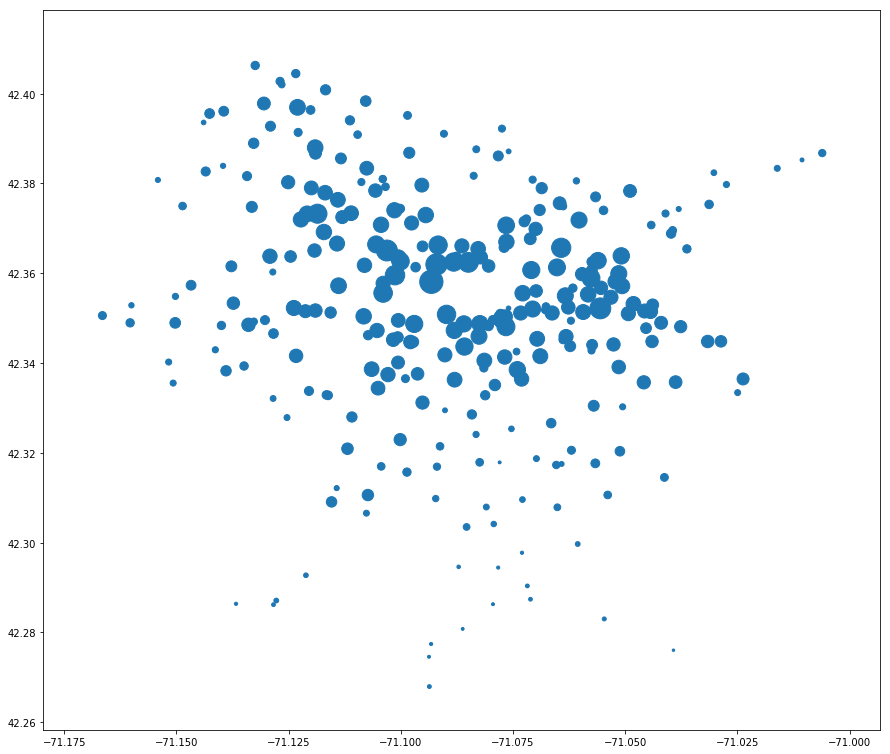

In [199]:
geometry = [Point(xy) for xy in zip(startinfo.long, startinfo.lat)]
startdf = gpd.GeoDataFrame(startinfo, crs=crs, geometry = geometry)
fig, ax=plt.subplots(figsize=(15,15))
startdf.plot(ax=ax, markersize=[math.pow(n, 0.55) for n in startdf["count"]])
plt.show()

In [172]:
geo_df.head()

,count,long,lat,geometry
start_station_name,,,,
175 N Harvard St,16266,-71.129164,42.363796,POINT (-71.129164 42.363796)
18 Dorrance Warehouse,305,-71.075978,42.387151,POINT (-71.07597800000001 42.387151)
191 Beacon St,1268,-71.108786,42.380323,POINT (-71.10878612855231 42.38032335045416)
30 Dane St,1374,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053)
30 Dane St.,1155,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053)


In [440]:
netinfo=startinfo.drop("geometry", axis=1).reset_index().merge(endinfo.drop("geometry", axis=1), how="inner").set_index("start_station_name")
netinfo.sort_index()


,count,long,lat
start_station_name,,,
BCBS Quincy,26,-71.039250,42.276005
Huntington Ave at Mass Art (former),321,-71.098969,42.336519
Mattapan Library,61,-71.093250,42.277389
Morton St T,38,-71.086218,42.280754


In [426]:
netinfo=netinfo.drop("geometry_y", axis=1)
netinfo.columns=["count_x", "long", "lat", "geometry", "count_y"]

In [427]:
netinfo.head()

,count_x,long,lat,geometry,count_y
0,16266,-71.129164,42.363796,POINT (-71.129164 42.363796),16597
1,305,-71.075978,42.387151,POINT (-71.07597800000001 42.387151),1089
2,1268,-71.108786,42.380323,POINT (-71.10878612855231 42.38032335045416),1255
3,1374,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053),1368
4,1374,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053),1135


In [432]:
netinfogeo.head()

NameError: name 'netinfogeo' is not defined

ValueError: Length of values does not match length of index

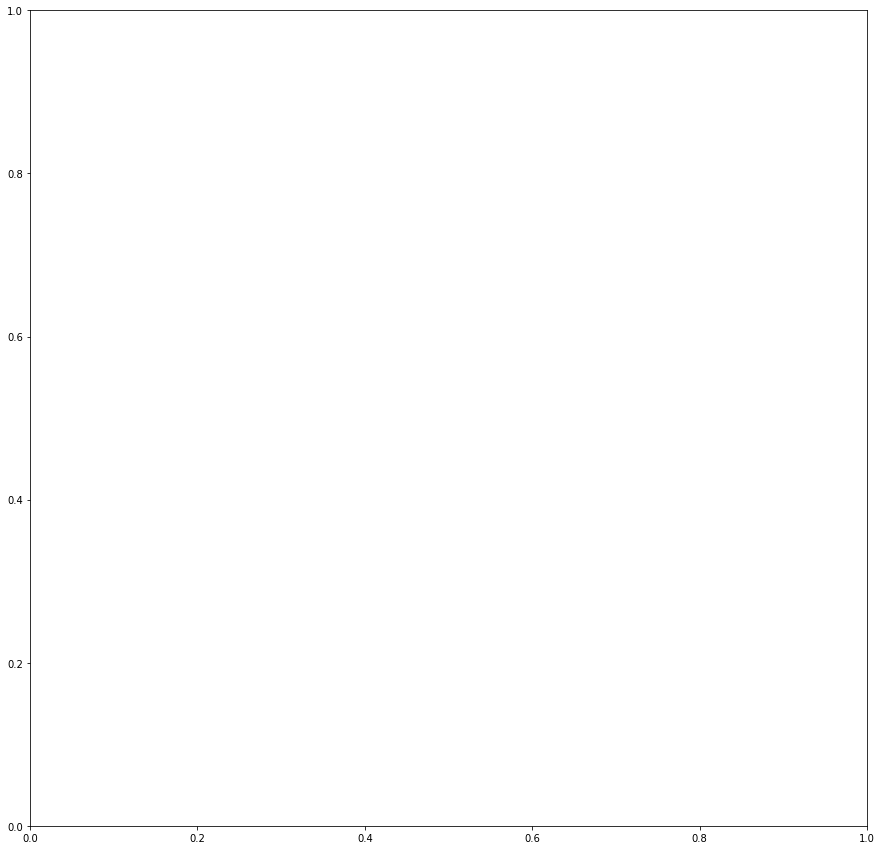

In [433]:
fig, ax=plt.subplots(figsize=(15,15))
netinfogeo=gpd.GeoDataFrame(netinfo, geometry = geometry)
netinfogeo.plot(ax=ax)
plt.show()

In [219]:
endinfo = endinfo.drop(["Lab PBSC","Test 000e3", "8D OPS 01", "8D QC Station 01", "8D QC Station 02","BCBS Hingham"])
geometry = [Point(xy) for xy in zip(endinfo.long, endinfo.lat)]
enddf = gpd.GeoDataFrame(endinfo, crs=crs, geometry = geometry)



In [253]:
enddf2 = enddf.sort_values("count", ascending=False)[:30]
startdf2 = startdf.sort_values("count", ascending=False)[:30]

In [417]:
startdf.head()

,count,long,lat,geometry
start_station_name,,,,
175 N Harvard St,16266,-71.129164,42.363796,POINT (-71.129164 42.363796)
18 Dorrance Warehouse,305,-71.075978,42.387151,POINT (-71.07597800000001 42.387151)
191 Beacon St,1268,-71.108786,42.380323,POINT (-71.10878612855231 42.38032335045416)
30 Dane St,1374,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053)
30 Dane St.,1155,-71.104025,42.381001,POINT (-71.10402522613184 42.38100143038053)


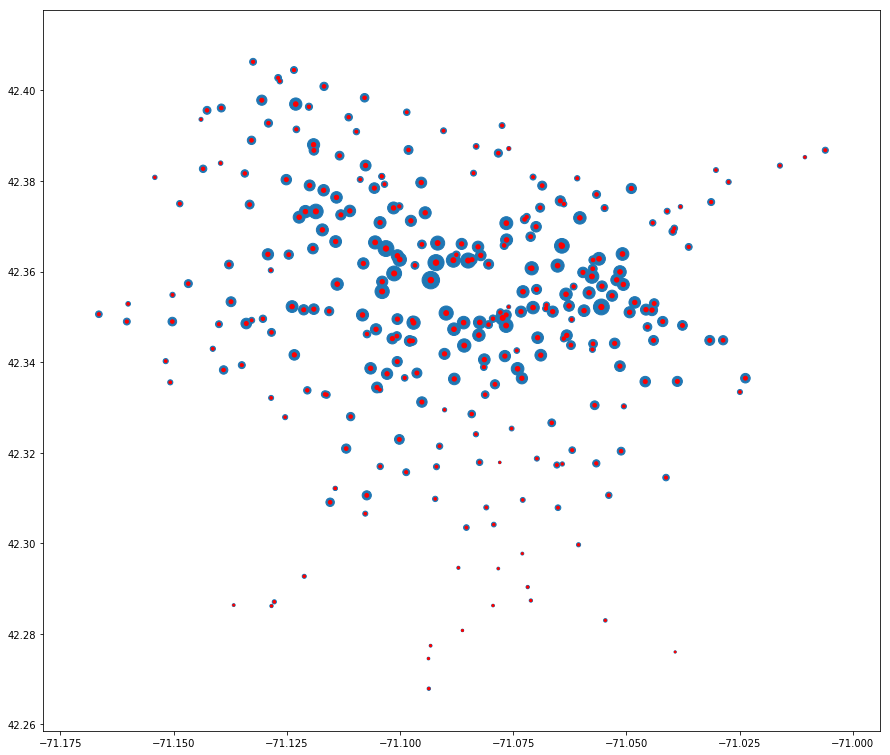

In [243]:
fig, ax=plt.subplots(figsize=(15,15))
startdf.plot(ax=ax, markersize=[math.pow(n, 0.5) for n in startdf["count"]])
enddf.plot(ax=ax, markersize=[math.pow(n, 0.3) for n in enddf["count"]], c="r")
plt.show()

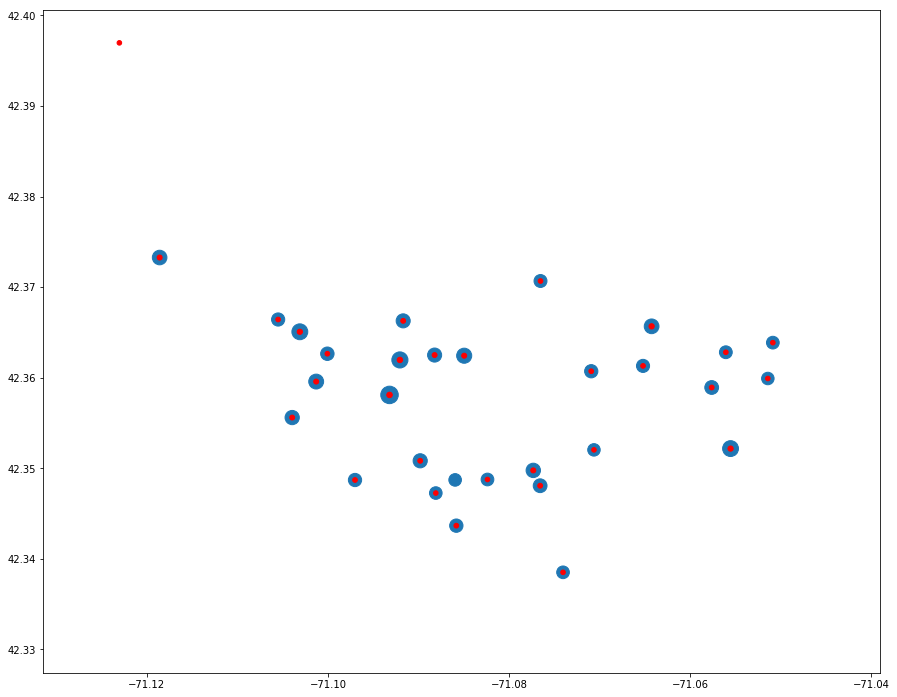

In [254]:
fig, ax=plt.subplots(figsize=(15,15))
startdf2.plot(ax=ax, markersize=[math.pow(n, 0.5) for n in startdf2["count"]])
enddf2.plot(ax=ax, markersize=[math.pow(n, 0.3) for n in enddf2["count"]], c="r")
plt.show()

In [262]:
bigdf[["start_station_name", "start_station_longitude", "start_station_latitude"]].groupby("start_station_name").first()[:10]

,start_station_longitude,start_station_latitude
start_station_name,,
175 N Harvard St,-71.129164,42.363796
18 Dorrance Warehouse,-71.075978,42.387151
191 Beacon St,-71.108786,42.380323
30 Dane St,-71.104025,42.381001
30 Dane St.,-71.104025,42.381001
30 Dane St. (former),-71.104100,42.381123
359 Broadway - Broadway at Fayette Street,-71.104412,42.370803
699 Mt Auburn St,-71.148630,42.374977
699 Mt Auburn St (former),-71.148630,42.374977


In [20]:
endsorted=bigdf.end_station_name.value_counts().sort_index()

In [43]:
startsorted.index.isin(endsorted.index)
endsorted[np.invert(endsorted.index.isin(startsorted.index))]

Lab PBSC    1
Name: end_station_name, dtype: int64

In [5]:
station = pd.read_csv("Hubway_Stations_as_of_July_2017.csv")

In [48]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 7 columns):
Station ID         281 non-null object
Station            281 non-null object
Latitude           281 non-null float64
Longitude          281 non-null float64
Municipality       281 non-null object
publiclyExposed    281 non-null int64
# of Docks         281 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 15.4+ KB


In [49]:
station.describe()

,Latitude,Longitude,publiclyExposed,# of Docks
count,281.000000,281.000000,281.000000,281.000000
mean,42.352018,-71.088944,0.964413,17.455516
std,0.027204,0.031670,0.185589,4.027448
min,42.267902,-71.166491,0.000000,10.000000
25%,42.338515,-71.112708,1.000000,15.000000
50%,42.352409,-71.087986,1.000000,15.000000
75%,42.371197,-71.064608,1.000000,19.000000
max,42.406302,-71.006098,1.000000,47.000000


In [263]:
startsorted[np.invert(startsorted.index.isin(station.Station))][:10]

18 Dorrance Warehouse                                                                305
30 Dane St                                                                          1374
30 Dane St. (former)                                                                 170
699 Mt Auburn St (former)                                                            286
8D OPS 01                                                                              2
8D QC Station 01                                                                       8
8D QC Station 02                                                                       3
Allston Green District - Griggs St at Commonwealth Ave TEMPORARY WINTER LOCATION    1323
Archdale Rd at Washington St (former)                                                 87
BCBS Hingham                                                                          56
Name: start_station_name, dtype: int64

In [117]:
station.Station[np.invert(station.Station.isin(endsorted.index))]

20                                               Ball Sq
124                        Harvard Ave at Glennville Ave
127    Harvard Real Estate - North Harvard St at West...
162                                Longwood Ave/Riverway
174                                  Milk St at India St
197                         Overland St at Brookline Ave
230                                      South Bay Plaza
239                               Summer St at Cutter St
243               TD Garden - Causeway at Portal Park #2
Name: Station, dtype: object

In [118]:
bigdftime=bigdf.set_index("starttime")

In [125]:
countperday=bigdftime.resample("D").count()

In [267]:
tripperday=countperday.tripduration
tripperday.head()

starttime
2017-07-01    4550
2017-07-02    4690
2017-07-03    5483
2017-07-04    5784
2017-07-05    6483
Freq: D, Name: tripduration, dtype: int64

In [107]:
geometry = [Point(xy) for xy in zip(station.Longitude, station.Latitude)]

In [108]:
geometry[:3]

In [12]:
crs={'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(station.Longitude, station.Latitude)]
geo_df = gpd.GeoDataFrame(station, crs=crs, geometry = geometry)
geo_df.head()



,Station ID,Station,Latitude,Longitude,Municipality,publiclyExposed,# of Docks,geometry
0,A32019,175 N Harvard St,42.363796,-71.129164,Boston,1,18,POINT (-71.129164 42.363796)
1,S32035,191 Beacon St,42.380323,-71.108786,Somerville,1,15,POINT (-71.10878613 42.38032335)
2,S32023,30 Dane St.,42.381001,-71.104025,Somerville,1,15,POINT (-71.10402523 42.38100143)
3,M32026,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,Cambridge,1,23,POINT (-71.104412 42.370803)
4,M32054,699 Mt Auburn St,42.375002,-71.148716,Cambridge,1,25,POINT (-71.14871614 42.37500235)


In [13]:
geo_df_new = geo_df.to_crs(epsg=26986)

In [14]:
geo_df_new.head()

,Station ID,Station,Latitude,Longitude,Municipality,publiclyExposed,# of Docks,geometry
0,A32019,175 N Harvard St,42.363796,-71.129164,Boston,1,18,POINT (230547.4228475936 901542.6633111662)
1,S32035,191 Beacon St,42.380323,-71.108786,Somerville,1,15,POINT (232217.6045848552 903385.9517461576)
2,S32023,30 Dane St.,42.381001,-71.104025,Somerville,1,15,POINT (232609.3254090853 903463.0793976233)
3,M32026,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,Cambridge,1,23,POINT (232582.7281295071 902330.13127581)
4,M32054,699 Mt Auburn St,42.375002,-71.148716,Cambridge,1,25,POINT (228931.7116248881 902780.6026825821)


In [8]:
geo_df.crs

{'init': 'epsg:26986'}

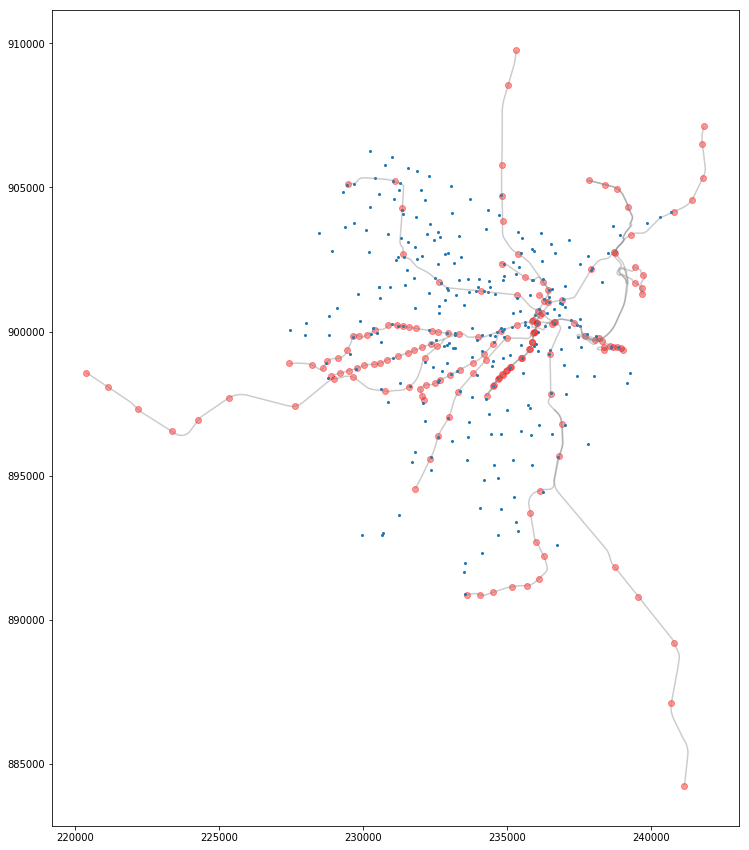

In [21]:
street_map= gpd.read_file("mbta_rapid_transit/MBTA_ARC.shp")
street_map_station= gpd.read_file("mbta_rapid_transit/MBTA_NODE.shp")
fig, ax=plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
street_map_station.plot(ax=ax, alpha=0.4, color="red")
geo_df_new.plot(ax=ax, markersize=4)
plt.show()

In [270]:
len(countperday["2018-03"])
len(weather_samp_samp.resample("D").first().DailyAverageDryBulbTemperature)

31

In [322]:
daily = pd.read_csv("DailyWeather.csv", low_memory=False, parse_dates=["DATE"])

In [329]:
daily=daily.set_index("DATE")

In [345]:
daily[daily.PSUN.notnull()].groupby("NAME").mean()

,STATION,LATITUDE,LONGITUDE,ELEVATION,AWND,PRCP,PSUN,SNOW,SNWD,TAVG,...,TSUN,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
NAME,,,,,,,,,,,,,,,,,,,,,
"BLUE HILL LCD, MA US",639,639,639,639,639,639,639,639,639,0,...,639,0,0,0,0,1,0,0,0,0


In [352]:
dailyBlueHill=daily[daily.NAME=="BLUE HILL LCD, MA US"]
dailyBlueHill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639 entries, 2017-07-01 to 2019-03-31
Data columns (total 23 columns):
STATION      639 non-null object
NAME         639 non-null object
LATITUDE     639 non-null float64
LONGITUDE    639 non-null float64
ELEVATION    639 non-null float64
AWND         639 non-null float64
PRCP         639 non-null float64
PSUN         639 non-null float64
SNOW         639 non-null float64
SNWD         639 non-null float64
TAVG         0 non-null float64
TMAX         639 non-null float64
TMIN         639 non-null float64
TSUN         639 non-null float64
WT01         0 non-null float64
WT02         0 non-null float64
WT03         0 non-null float64
WT04         0 non-null float64
WT05         1 non-null float64
WT06         0 non-null float64
WT08         0 non-null float64
WT09         0 non-null float64
WT11         0 non-null float64
dtypes: float64(21), object(2)
memory usage: 119.8+ KB


In [349]:
dailyBoston=daily[daily.NAME=="BOSTON, MA US"]

In [336]:
dailyBoston=dailyBoston.drop("ELEVATION", axis=1)

In [354]:
dailyBoston.TAVG

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,PRCP,PSUN,SNOW,SNWD,...,TSUN,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
DATE,,,,,,,,,,,,,,,,,,,,,
2017-07-01,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,13.87,0.11,NaN,0.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-02,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,11.41,0.00,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-03,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,12.97,0.00,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-04,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,6.26,0.00,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-05,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,8.50,0.00,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-06,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,9.62,0.00,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-07,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,8.28,0.30,NaN,0.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-08,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,9.17,0.40,NaN,0.0,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-09,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,11.86,0.00,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


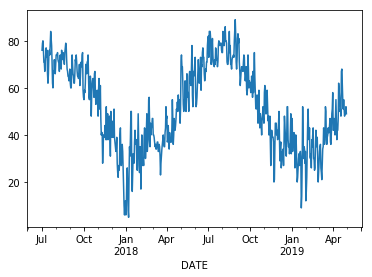

In [355]:
dailyBoston.TAVG.plot()

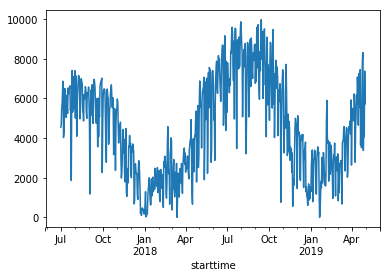

In [362]:
bigdftime.resample("D").count().tripduration.plot()

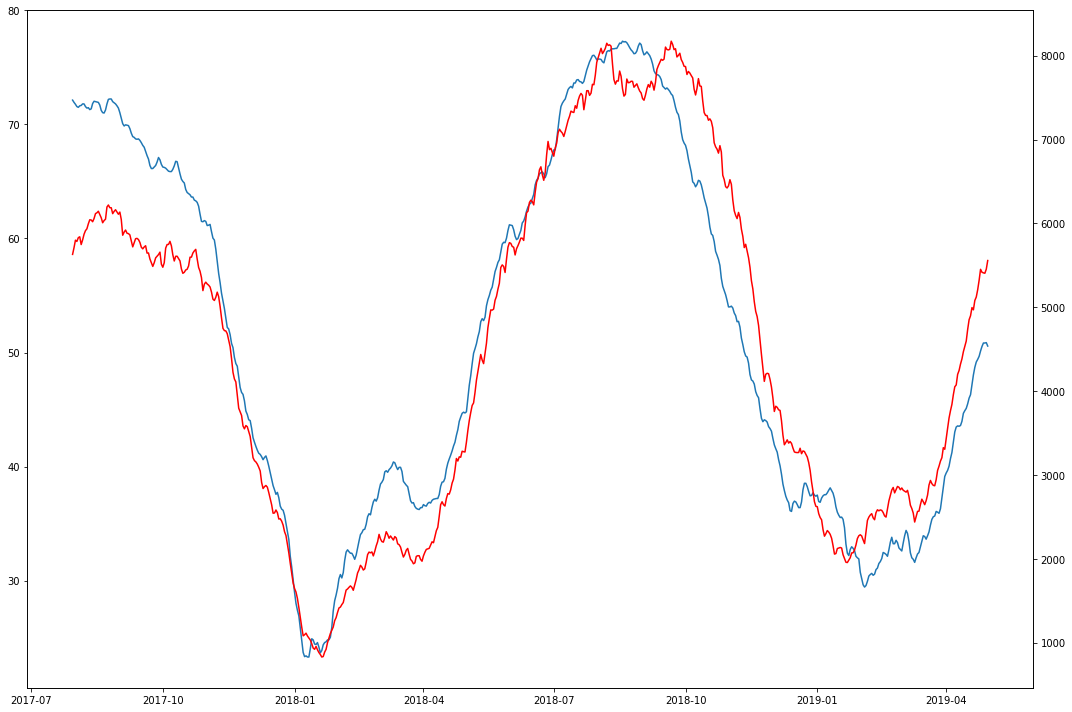

In [391]:

fig, ax1 = plt.subplots(figsize=(15,10))


ax1.plot(dailyBoston.TAVG.rolling(30).mean())

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.plot(bigdftime.resample("D").count().tripduration.rolling(30).mean(), color="red")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:

fig, ax1 = plt.subplots(figsize=(15,10))


ax1.plot(dailyBoston.TAVG)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.plot(bigdftime.resample("D").count().tripduration, color="red")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

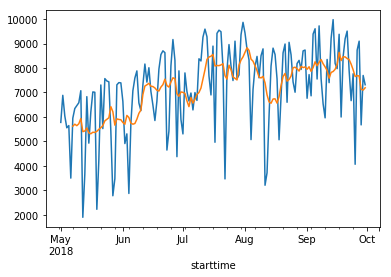

In [389]:
bigdftime["2018-05":"2018-09"].resample("D").count().tripduration.plot()
bigdftime["2018-05":"2018-09"].resample("D").count().tripduration.rolling(7).mean().plot()

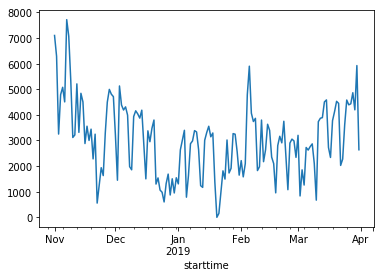

In [380]:
bigdftime["2018-11":"2019-03"].resample("D").count().tripduration.plot()

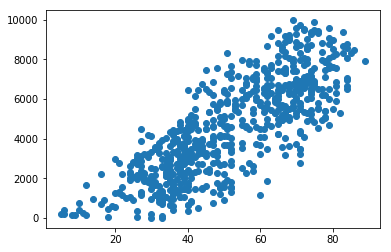

In [363]:
plt.scatter(dailyBoston.TAVG, bigdftime.resample("D").count().tripduration)

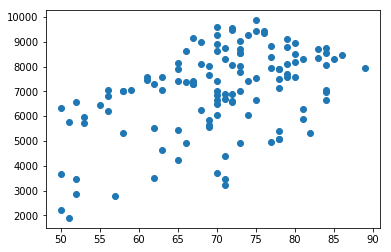

In [376]:
plt.ylim=(-1000, 10000)
plt.xlim=(30, 90)
plt.scatter(dailyBoston["2018-05":"2018-08"].TAVG, bigdftime["2018-05":"2018-08"].resample("D").count().tripduration)
plt.show()

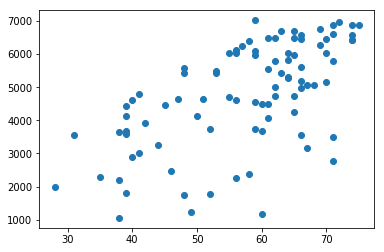

In [365]:
plt.scatter(dailyBoston["2017-09":"2017-11"].TAVG, bigdftime["2017-09":"2017-11"].resample("D").count().tripduration)

In [315]:

weather = pd.read_csv("WeatherBoston.csv", low_memory=False, parse_dates=["DATE"])
#weather_core= weather[["STATION_NAME", "DATE", "DailyAverageDryBulbTemperature", "DailyPrecipitation", "DailySnowfall", "DailySnowDepth"]]
#weather_core.set_index(["DATE"]).resample("D").first()
#weather_samp_samp=weather_samp_samp.set_index(["DATE"])

#plt.clf()
weather.head()


,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72509014739,2017-07-01 00:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
1,72509014739,2017-07-01 01:00:00,FM-12,4,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
2,72509014739,2017-07-01 01:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
3,72509014739,2017-07-01 02:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
4,72509014739,2017-07-01 03:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05


In [298]:
weather.head(40)

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72509014739,2017-07-01T00:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
1,72509014739,2017-07-01T01:00:00,FM-12,4,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
2,72509014739,2017-07-01T01:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
3,72509014739,2017-07-01T02:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
4,72509014739,2017-07-01T03:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
5,72509014739,2017-07-01T04:00:00,FM-12,4,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
6,72509014739,2017-07-01T04:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
7,72509014739,2017-07-01T05:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
8,72509014739,2017-07-01T06:54:00,FM-15,7,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05
9,72509014739,2017-07-01T07:00:00,FM-12,4,NaN,NE,2.22,mi,SNOW,32.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-05


In [316]:
weather1=weather.drop(["REPORT_TYPE", "SOURCE", "AWND", "BackupDirection", "BackupDistance", "BackupDistanceUnit"], axis=1)

In [317]:
weather2=weather1.drop(["BackupElevation", "BackupElevationUnit", "BackupEquipment", "Sunrise", "Sunset", "WindEquipmentChangeDate"], axis=1)

Index(['STATION', 'DATE', 'BackupElements', 'BackupLatitude',
       'BackupLongitude', 'BackupName', 'CDSD', 'CLDD', 'DSNW',
       'DailyAverageDewPointTemperature',
       ...
       'ShortDurationPrecipitationValue020',
       'ShortDurationPrecipitationValue030',
       'ShortDurationPrecipitationValue045',
       'ShortDurationPrecipitationValue060',
       'ShortDurationPrecipitationValue080',
       'ShortDurationPrecipitationValue100',
       'ShortDurationPrecipitationValue120',
       'ShortDurationPrecipitationValue150',
       'ShortDurationPrecipitationValue180', 'TStorms'],
      dtype='object', length=112)

In [293]:
weather2.columns[0:10]

Index(['STATION', 'DATE', 'BackupElements', 'BackupLatitude',
       'BackupLongitude', 'BackupName', 'CDSD', 'CLDD', 'DSNW',
       'DailyAverageDewPointTemperature'],
      dtype='object')

In [294]:
weather2.columns[10:20]

Index(['DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity',
       'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure',
       'DailyAverageWetBulbTemperature', 'DailyAverageWindSpeed',
       'DailyCoolingDegreeDays', 'DailyDepartureFromNormalAverageTemperature',
       'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature'],
      dtype='object')

In [310]:
weather2.columns[20:40]

Index(['DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection',
       'DailyPeakWindSpeed', 'DailyPrecipitation', 'DailySnowDepth',
       'DailySnowfall', 'DailySustainedWindDirection',
       'DailySustainedWindSpeed', 'DailyWeather', 'HDSD', 'HTDD', 'HeavyFog',
       'HourlyAltimeterSetting', 'HourlyDewPointTemperature',
       'HourlyDryBulbTemperature', 'HourlyPrecipitation',
       'HourlyPresentWeatherType', 'HourlyPressureChange',
       'HourlyPressureTendency', 'HourlyRelativeHumidity'],
      dtype='object')

In [296]:
weather2.columns[40:60]

Index(['HourlySeaLevelPressure', 'HourlySkyConditions',
       'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature',
       'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
       'MonthlyAverageRH', 'MonthlyDaysWithGT001Precip',
       'MonthlyDaysWithGT010Precip', 'MonthlyDaysWithGT32Temp',
       'MonthlyDaysWithGT90Temp', 'MonthlyDaysWithLT0Temp',
       'MonthlyDaysWithLT32Temp',
       'MonthlyDepartureFromNormalAverageTemperature',
       'MonthlyDepartureFromNormalCoolingDegreeDays',
       'MonthlyDepartureFromNormalHeatingDegreeDays',
       'MonthlyDepartureFromNormalMaximumTemperature',
       'MonthlyDepartureFromNormalMinimumTemperature'],
      dtype='object')

In [318]:
weather3=weather2.iloc[:,[0, 1, 3, 4, 5, 10, 15, 19, 20, 23, 24, 25, 28, 29, 30, 31, 111]]

In [319]:
weather3.set_index(["DATE"]).resample("D").first()

,STATION,BackupLatitude,BackupLongitude,BackupName,DailyAverageDryBulbTemperature,DailyAverageWindSpeed,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailyWeather,HDSD,HTDD,HeavyFog,TStorms
DATE,,,,,,,,,,,,,,,,
2017-07-01,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",79.0,13.8,88.0,69.0,0.11,NaN,0.0,RA,NaN,NaN,NaN,NaN
2017-07-02,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",81.0,11.4,90.0,71.0,T,NaN,0.0,RA,NaN,NaN,NaN,NaN
2017-07-03,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",79.0,12.9,87.0,71.0,T,NaN,0.0,RA,NaN,NaN,NaN,NaN
2017-07-04,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",75.0,6.2,82.0,67.0,0.00,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2017-07-05,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",71.0,8.4,79.0,62.0,0.00,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2017-07-06,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",72.0,9.6,83.0,61.0,0.00,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2017-07-07,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",66.0,8.2,70.0,62.0,0.30,NaN,0.0,RA DZ BR,NaN,NaN,NaN,NaN
2017-07-08,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",75.0,9.1,87.0,63.0,0.40,NaN,0.0,TS RA BR,NaN,NaN,NaN,NaN
2017-07-09,72509014739,42.3842,-70.9803,"KENNEDY RD, WINTHROP",75.0,11.9,83.0,66.0,0.00,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [320]:
weather3.set_index(["DATE"]).resample("D").mean()

,STATION,BackupLatitude,BackupLongitude,DailyAverageDryBulbTemperature,DailyAverageWindSpeed,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailySnowDepth,HDSD,HTDD,HeavyFog,TStorms
DATE,,,,,,,,,,,,
2017-07-01,72509014739,42.3842,-70.9803,79.0,13.8,88.0,69.0,NaN,NaN,NaN,NaN,NaN
2017-07-02,72509014739,42.3842,-70.9803,81.0,11.4,90.0,71.0,NaN,NaN,NaN,NaN,NaN
2017-07-03,72509014739,42.3842,-70.9803,79.0,12.9,87.0,71.0,NaN,NaN,NaN,NaN,NaN
2017-07-04,72509014739,42.3842,-70.9803,75.0,6.2,82.0,67.0,NaN,NaN,NaN,NaN,NaN
2017-07-05,72509014739,42.3842,-70.9803,71.0,8.4,79.0,62.0,NaN,NaN,NaN,NaN,NaN
2017-07-06,72509014739,42.3842,-70.9803,72.0,9.6,83.0,61.0,NaN,NaN,NaN,NaN,NaN
2017-07-07,72509014739,42.3842,-70.9803,66.0,8.2,70.0,62.0,NaN,NaN,NaN,NaN,NaN
2017-07-08,72509014739,42.3842,-70.9803,75.0,9.1,87.0,63.0,NaN,NaN,NaN,NaN,NaN
2017-07-09,72509014739,42.3842,-70.9803,75.0,11.9,83.0,66.0,NaN,NaN,NaN,NaN,NaN


In [138]:

weather_samp = pd.read_csv("weathersample.csv", parse_dates=["DATE"])
weather_samp_samp=weather_samp.iloc[:, :40]
weather_samp_samp = weather_samp_samp[["STATION_NAME", "DATE", "DailyAverageDryBulbTemperature", "DailyPrecipitation", "DailySnowfall", "DailySnowDepth"]]

weather_samp_samp.set_index(["DATE"]).resample("D").first()
weather_samp_samp=weather_samp_samp.set_index(["DATE"])
plt.plot(countperday["2018-03"])
plt.clf()

<Figure size 432x288 with 0 Axes>

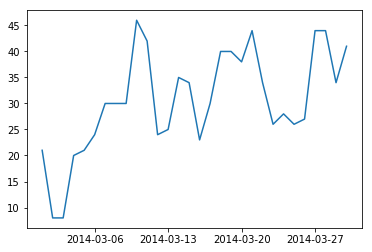

In [139]:
plt.plot(weather_samp_samp.resample("D").first().DailyAverageDryBulbTemperature)

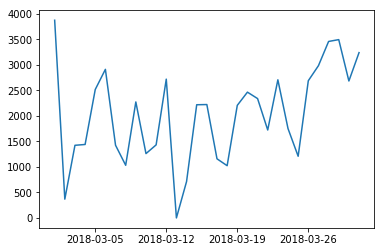

In [142]:
plt.plot(countperday["2018-03"].tripduration)

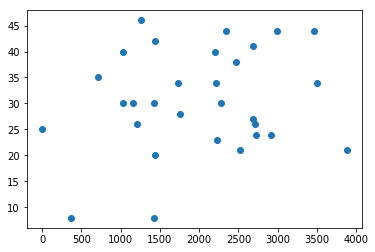

In [143]:
plt.scatter(countperday["2018-03"].tripduration,weather_samp_samp.resample("D").first().DailyAverageDryBulbTemperature )